# Simulation of a commodity market allocation

2024-08-16

Consider the following system:
- There are N coal mines at locations {ui} with unique mining unit costs {ci}
- There are M power plants at locations {wi} consuming coal to produce power with ICAPs {Pi}
- There is a fixed unit transport cost per tonne-km, so the transport cost rises linearly with distance
- There is a fixed power price, which puts a ceiling to the coal price


Assumptions:
- Uniform coal quality
- Uniform plant efficiencies
- Uniform plant capacities, which translates to coal volumes

Additional things to assume:
- Mines have fixed capacities

Questions:
- What is the settled coal price FOB mine for all the mines?

## Monte Carlo simulation

### Initial allocation
- For each plant, allocate volumes uniformly


### MC step
Types of steps:
- change in volumes between mines: cross swapping
- change in prices: increases or decreases, acceptance based on unit costs/power costs

Cross swapping:
1. Select two mines and two plants randomly
2. Take a trial step: move coal from mine A and plant B to mine B and plant A
3. Compute difference in price
4. If price lower, accept
5. If price higher, accept with exp(-delta c / T), else reject

Price change:
1. Randomly select a mine and a plant
2. Increase the price
3. If within limits of mine cash costs and power cost, accept
4. If out of the limits, accept with exp(- delta c /T), else reject

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

pd.options.plotting.backend = "plotly"

In [67]:
from scipy.optimize import minimize, Bounds, LinearConstraint

In [124]:
np.set_printoptions(linewidth=200)

## 1. Create the system

Assumptions:
- ca 500x500km area with ~10 mines
- coal has standard calorific value 25 GJ/t
- no emission permits
- global coal plant load factor 50%

In [4]:
# simple computation 

eta = 0.35
heat_rate = 3.6 / eta

coal_density = 25.0 # GJ/t

lf_mean = 0.7

# global parameters
global_gen = 30*5

In [5]:
N = 10
M = 15

D = 500.0
sgma_D = 10.0

In [6]:
# define locations
np.random.seed(42)

loc_mine = np.random.rand(N, 2) * D
loc_plant = np.random.rand(M, 2) * D

# compute distance matrix
DM = np.array([[np.linalg.norm(loc_mine[i] - loc_plant[j]) for j in range(M)] for i in range(N)])

#### Mining

In [7]:
# define cash costs

cc_mean = 100 / coal_density  # USD/GJ
cc_std = 30 / coal_density

np.random.seed(41)

N = 10
vec_cc = np.random.normal(cc_mean, cc_std, N)
vec_volumes = np.random.exponential(4.0, N)
vec_volumes = np.ones_like(vec_cc) * 4.0

In [92]:
df_mines = pd.DataFrame({'cc': vec_cc, 'volume': vec_volumes})
df_mines = df_mines.sort_values('cc')
df_mines['cum_volume'] = df_mines['volume'].cumsum()

In [93]:
# show that cash costs lie on a typical cost curve
cum_cc = np.cumsum(np.sort(df_mines))

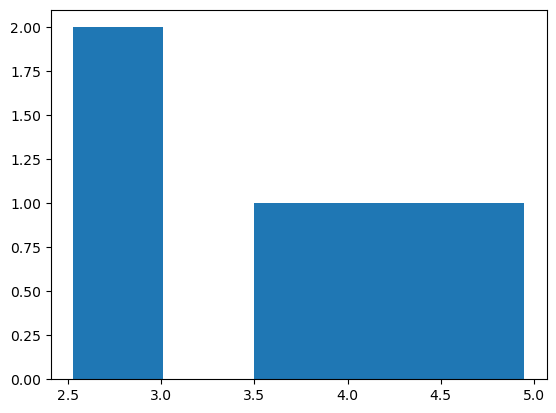

In [94]:
plt.hist(df_mines['cc'], bins=10);

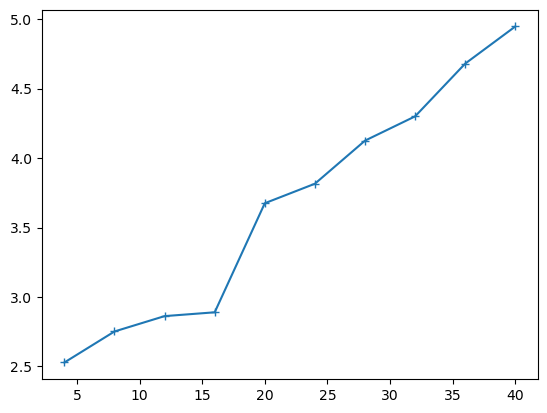

In [95]:
plt.plot(df_mines['cum_volume'], df_mines['cc'], '+-')
# plt.ylim(2, 6)

## 1. Write structured object-oriented code

Bad idea, aborting.

In [8]:
def create_distance_matrix(v, w):
    M = len(v)
    N = len(w)
    return np.array([[np.linalg.norm(v[i] - w[j]) for j in range(N)] for i in range(M)])

In [102]:
COAL_DENSITY = 25.0
MEAN_CC = 100.0 / COAL_DENSITY
STD_CC = 30.0 / COAL_DENSITY

In [99]:
class MCSim:
    def __init__(self, loc_mine, loc_plant, vec_cc, vec_cap) -> None:
        np.random.seed(42)

        self.M = len(loc_mine)
        self.N = len(loc_plant)

        # mine data
        self.vec_mine_vols = np.zeros_like(self.vec_cc)

        # plant data
        LF_mean = 0.5
        ETA = 0.33
        HR = 3.6 / ETA
        SINGLE_ICAP_GW = 1.0
        SINGLE_ICAP_TWH = SINGLE_ICAP_GW * 8.76
        SINGLE_ICAP_GJ = SINGLE_ICAP_TWH * HR
        TOT_ICAP_TWH = self.N * SINGLE_ICAP_TWH
        TOT_DEMAND_TWH = TOT_ICAP_TWH * LF_mean
        TOT_DEMAND_GJ = TOT_DEMAND_TWH * HR
        AVG_MINE_DEMAND_GJ = TOT_DEMAND_GJ / self.M

        # distances / matrices
        self.UNIT_FREIGHT = 0.05
        self.loc_mine = loc_mine
        self.loc_plant = loc_plant
        self.DM = create_distance_matrix(self.loc_mine, self.loc_plant)

        self.COSTS = np.zeros((self.M, self.N))  # matrix of costs for each mine-plant pair
        self.VOLUMES = np.zeros((self.M, self.N))  # matrix of volume flows for each mine-plant pair

        # mine vectors
        self.vec_cc = np.random.normal(MEAN_CC, STD_CC, self.N)  # fixed
        self.vec_mine_prices = np.zeros_like(self.vec_cc)  # variable
        self.vec_volumes = np.zeros_like(self.vec_cc)  # variable

        # plant vectors
        self.vec_icap = np.ones(self.N) * SINGLE_ICAP_GJ  # fixed
        self.vec_gen = np.ones(self.N) * SINGLE_ICAP_GJ * LF_mean  # variable
        self.vec_plant_prices = np.zeros(self.N)  # variable     

        # simulation parameters
        self.T = 1.0

    def initialise_flows(self):
        pass

    def simulate(self):
        pass

In [1]:
# Finish...

## 2. Brute-force minimisation with Scipy of total cost given the constraints

As an approximation to the Nash equilibrium (though minimisation does not guarantee NE).

List of constraints:
- mine volumes: between 0 and 4, need to sum by rows
- plant volumes: between 0 and 8, need to sum by columns
- prices: above the mine cash costs, reproduce by rows
- demand: all volume must sum to total demand

Tutorial: https://docs.scipy.org/doc/scipy/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize

In [57]:
def total_cost(mat_volumes, mat_prices, mat_freight):
    return np.sum(mat_volumes * mat_prices) + np.sum(mat_volumes * mat_freight)


def total_cost_squeezed(x, mat_freight):
    mat_volumes = np.reshape(x[:N*N], (N, N))
    mat_prices = np.reshape(x[N*N:2*N*N], (N, N))
    return total_cost(mat_volumes, mat_prices, mat_freight)

In [160]:
def build_constraints(N, vec_mine_costs, TOT_DEMAND, vec_mine_cap, vec_plant_cap):
    '''
    Build constraints for the optimization problem
    NEXT STEP: generalise for unequal mine and plant numbers
    '''
    no_volume_constraint = [0] * N*N
    no_price_constraint = [0] * N*N

    constraints = []
    lows = []
    highs = []

    # mine capacity constraints
    for i in range(N):
        cons = [0] * N * i + [1] * N + [0] * N * (N - i - 1)
        constraints.append(cons + no_price_constraint)
        lows.append(0)
        highs.append(vec_mine_cap[i])

    # individual mine volume constraints
    for i in range(N):
       for j in range(N):
            cons = [0] * N * i + ([0]*j + [1] + [0]*(N-j-1)) + [0] * N * (N - i - 1)
            constraints.append(cons + no_price_constraint)
            lows.append(0)
            highs.append(vec_mine_cap[i])

    # plant capacity constraints
    for i in range(N):
        cons = ([0] * i + [1] + [0] * (N - i - 1)) * 3
        constraints.append(cons + no_price_constraint)
        lows.append(0)
        highs.append(vec_plant_cap[i])

    # individual plant capacity constraints
    for i in range(N):
        for j in range(N):
            cons = [0] * N * i + ([0]*j + [1] + [0]*(N-j-1)) + [0] * N * (N - i - 1)
            constraints.append(cons + no_price_constraint)
            lows.append(0)
            highs.append(vec_plant_cap[j])

    # mine cost constraints
    for i in range(N):
        for j in range(N):
            cons = [0] * N * i + ([0]*j + [1] + [0]*(N-j-1)) + [0] * N * (N - i - 1)
            constraints.append(no_volume_constraint + cons)
            lows.append(vec_mine_costs[i])
            highs.append(np.inf)

    # demand constraint
    cons = [1] * N*N
    constraints.append(cons + no_price_constraint)
    lows.append(TOT_DEMAND)
    highs.append(TOT_DEMAND*1.2)

    return constraints, lows, highs

In [99]:
np.random.seed(42)

N = 3
UNIT_FREIGHT = 0.05
LF = 0.25
MINE_CAP = 4.0

# input vectors
vec_mine_costs = np.linspace(80, 120, N)  # np.random.normal(100, 30, N)
vec_mine_cap = np.ones_like(vec_mine_costs) * MINE_CAP
vec_plant_cap = np.ones_like(vec_mine_costs) * 8.0

# output vectors
vec_plant_lf = np.ones_like(vec_mine_costs) * LF
vec_plant_volume = vec_plant_cap * vec_plant_lf
vec_mine_volume = vec_plant_volume

# aggregated variables
TOT_DEMAND = vec_plant_volume.sum()
TOT_MINE_CAP = vec_mine_cap.sum()
TOT_PLANT_CAP = vec_plant_cap.sum()

# input matrices
loc_mines = np.random.rand(N, 2) * 500
loc_plants = np.random.rand(N, 2) * 500
mat_distances = create_distance_matrix(loc_mines, loc_plants)
mat_freight = UNIT_FREIGHT * mat_distances

# output matrices
mat_volumes = np.diag(vec_mine_volume)
mat_prices = np.diag(vec_mine_costs)

In [58]:
total_cost(mat_volumes, mat_prices, mat_freight)

666.1624739684947

In [72]:
# no constraints
res = minimize(total_cost_squeezed, [*mat_volumes.flatten(), *mat_prices.flatten()], args=(mat_freight,))
res

In [161]:
c, l, h = build_constraints(N, vec_mine_costs, TOT_DEMAND, vec_mine_cap, vec_plant_cap)

In [162]:
np.c_[c, l, h]

array([[  1. ,   1. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  0. ,   0. ,   0. ,   1. ,   1. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   4. ],
       [  0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. , 

In [163]:
# # constraint on total traded volume
# no_price_constraint = [0] * (N*N)

# # individual mine volumes
# # generalise for any N
# mine_1 = [1] * N + [0] * N * (N-1)
# mine_2 = [0] * N + [1] * N + [0] * N * (N-2)  # generalise
# mine_3 = [0] * N * (N-1) + [1] * N

# linear_constraint = LinearConstraint(
#     [
#         [1] * (N*N) + no_price_constraint,
#         mine_1 + no_price_constraint,
#         mine_2 + no_price_constraint,
#         mine_3 + no_price_constraint,
#     ]
#     [TOT_MINE_VOLUME] + [0] * N,
#     [TOT_MINE_VOLUME] + [MINE_CAP] * N
# )


# # constraint on individual mine volumes and prices
# mine_vols_low = np.zeros(N)
# mine_vols_high = vec_mine_volume
# bounds = Bounds([0.0] * (N*N*2), [np.inf] * (N*N*2))

In [164]:
linear_constraint = LinearConstraint(c, l, h)

OptimizeWarning: 

Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 

  warn("Equality and inequality constraints are specified in the same "

In [165]:
# with constraints
res = minimize(
    total_cost_squeezed,
    [*mat_volumes.flatten(), *mat_prices.flatten()],
    args=(mat_freight,),
    constraints=linear_constraint
)

In [166]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 561.2848318233706
       x: [ 4.000e+00 -7.627e-08 ...  1.206e+02  1.200e+02]
     nit: 18
     jac: [ 8.819e+01  8.830e+01 ...  0.000e+00  0.000e+00]
    nfev: 296
    njev: 14

In [282]:
def visualise_results_scipy(res, N, mat_freight):
    '''Show results in a simple dataframe for visual exploration'''
    dfvol = pd.DataFrame(res.x[:N*N].reshape((N, N)).round(1), columns=list('abc'))
    dfprice = pd.DataFrame(res.x[N*N:].reshape((N, N)).round(1), columns=list('abc'))
    dffreight = pd.DataFrame(mat_freight.round(1), columns=list('abc'))
    df = pd.concat([dfvol, dfprice, dffreight], axis=1, keys=['Volumes', 'Prices', 'Freight'])
    return df

In [284]:
visualise_results_scipy(res, N, mat_freight)

Volumes           Prices               Freight          
        a    b    c      a      b      c       a    b    c
0     0.0  1.6  1.6   80.0   80.0   80.0     1.0  1.0  1.0
1     1.6  0.0  1.6  110.0  110.0  110.0     1.0  1.0  1.0
2     1.6  1.6  0.0  140.0  140.0  140.0     1.0  1.0  1.0

In [170]:
# freight matrix
mat_freight.round(1)

array([[ 8.2,  8.3,  8.9],
       [18.1,  4.3, 20.1],
       [17.9, 17.7, 20.6]])

Notes:
- bad result, as this does not give unified price
- not clear what should be minimised

## 3. Exploration of variants

### 3.1. Constant freight: show that price is indeed 

In [235]:
seed = 42
np.random.seed(seed)

N = 3
LF = 0.4
MINE_CAP = 4.0
PLANT_CAP = 8.0
UNIT_FREIGHT = 0.0001
FREIGHT_CONST = 1.0

# input vectors
vec_mine_costs = np.linspace(80, 140, N)
vec_mine_cap = np.ones_like(vec_mine_costs) * MINE_CAP
vec_plant_cap = np.ones_like(vec_mine_costs) * PLANT_CAP

# output vectors
vec_plant_lf = np.ones(N) * LF
vec_plant_volume = vec_plant_cap * vec_plant_lf
vec_mine_volume = vec_plant_volume

# aggregated variables
TOT_DEMAND = vec_plant_volume.sum()
TOT_MINE_CAP = vec_mine_cap.sum()
TOT_PLANT_CAP = vec_plant_cap.sum()

# input matrices
loc_mines = np.random.rand(N, 2) * 500
loc_plants = np.random.rand(N, 2) * 500
mat_distances = create_distance_matrix(loc_mines, loc_plants)
mat_freight = UNIT_FREIGHT * mat_distances
mat_freight = np.ones((N, N)) * FREIGHT_CONST

# output matrices
mat_volumes = np.diag(vec_mine_volume)
mat_prices = np.diag(vec_mine_costs)

In [236]:
c, l, h = build_constraints(N, vec_mine_costs, TOT_DEMAND, vec_mine_cap, vec_plant_cap)
linear_constraint = LinearConstraint(c, l, h)

In [237]:
res = minimize(
    total_cost_squeezed,
    [*mat_volumes.flatten(), *mat_prices.flatten()],
    args=(mat_freight,),
    constraints=linear_constraint
)

In [238]:
visualise_results(res, N, mat_freight)

Volumes           Prices               Freight          
        a    b    c      a      b      c       a    b    c
0     0.0  1.6  1.6   80.0   80.0   80.0     1.0  1.0  1.0
1     1.6  0.0  1.6  110.0  110.0  110.0     1.0  1.0  1.0
2     1.6  1.6  0.0  140.0  140.0  140.0     1.0  1.0  1.0

Results:
- wrong horizontal allocation, fixable: despite degeneracy (multiple plants can take for same price), all volume allocated to one plant
- wrong vertical allocation, serious: plants take from too expensive mines

## 4. Return to MC simulations

Several basic MC steps:
- transfer volumes for chosen miner between plants horizontally (given constraints of capacities)
- transfer volumes for chosen plant between miners vertically (given capacity constraints)
- increase price of (i, j)
- decrease price of (i, j)

Price decrease rules:
- miner tries to increase by dP: if
- power plant tries to decrease by dP

Consider if the price decrease should be somehow.

#### Quasi-deterministic algo
- randomly transfer volume horizontally
    - accept if the price is higher or equal
    - reject otherwise
- randomly transfer volume vertically
    - accept if the price is lower or equal
    - reject otherwise
- randomly increase price (PP unhappy):
    - accept if no better choice for PP
    - reject otherwise (debatable)
- randomly decrease price (M unhappy):
    - accept if no better choice for M
    - reject otherwise (debatable)


#### Quasi-deterministic implementation

In [319]:
def visualise_results(mat_volumes, mat_prices, mat_freight):
    '''Show results in a simple dataframe for visual exploration'''
    dfvol = pd.DataFrame(mat_volumes.round(1), columns=list('abc'))
    dfprice = pd.DataFrame(mat_prices.round(1), columns=list('abc'))
    dffreight = pd.DataFrame(mat_freight.round(1), columns=list('abc'))
    df = pd.concat([dfvol, dfprice, dffreight], axis=1, keys=['Volumes', 'Prices', 'Freight'])
    return df

def check_volume_bounds(mat_volumes, vec_mine_cap, vec_plant_cap):
    return np.all(mat_volumes.sum(axis=1) <= vec_mine_cap) and \
        np.all(mat_volumes.sum(axis=1) >= 0) and \
        np.all(mat_volumes.sum(axis=0) <= vec_plant_cap) and \
        np.all(mat_volumes.sum(axis=0) >= 0) and \
        np.all(mat_volumes >= 0)

In [432]:
N = 3
LF = 0.25
MINE_CAP = 4.0
PLANT_CAP = 8.0
FREIGHT_CONST = 1.0

vec_mine_volume = np.ones(N) * PLANT_CAP * LF

mat_volumes = np.diag(vec_mine_volume)
mat_prices = np.outer(vec_mine_costs, np.ones(N))
mat_freight = np.ones((N, N)) * FREIGHT_CONST

delta_V = 0.05  # volume change
delta_P = 1.0  # price change

n_steps = int(5e3)

steps = {
    'volume_h': 0,
    'volume_v': 0,
    'price_up': 0,
    'price_down': 0,
}
history = []

verbose = False
np.random.seed(43)

In [433]:
for istep in range(n_steps):
    '''
    Change volume horizontally to improve M position
    '''
    i = np.random.choice(N)
    while True:
        j1 = np.random.choice(N)
        j2 = np.random.choice(N)
        if j1 != j2:
            break
    mat_volumes[i, j1] -= delta_V
    mat_volumes[i, j2] += delta_V
    # price change for M, accept if new price higher    
    p1, p2 = mat_prices[i, j1], mat_prices[i, j2]
    dP = (p2 - p1) * delta_V
    if dP >= 0.0 and check_volume_bounds(mat_volumes, vec_mine_cap, vec_plant_cap):
        steps['volume_h'] += 1
        if verbose:
            print(f'Volume transfer horizontal from {i}, {j1} to {j2} by {delta_V}')
    else:
        mat_volumes[i, j1] += delta_V
        mat_volumes[i, j2] -= delta_V
    
    '''
    Random price increase, benefiting miners
    '''
    i = np.random.choice(N)
    j = np.random.choice(N)
    new_price = mat_prices[i, j] + delta_P
    # accept if no alternative, otherwise leave as is
    tmp = (mat_prices[:, j] + mat_freight[:, j]).copy()
    tmp[i] = np.inf  # dummy infinity
    if new_price <= np.min(tmp):
        mat_prices[i, j] = new_price
        steps['price_up'] += 1
        if verbose:
            print(f'Price increase at {i}, {j} by {delta_P}')

    '''
    Change volume vertically to improve PP position
    '''
    j = np.random.choice(N)
    while True:
        i1 = np.random.choice(N)
        i2 = np.random.choice(N)
        if i1 != i2:
            break
    mat_volumes[i1, j] -= delta_V
    mat_volumes[i2, j] += delta_V
    # price change for PP, accept if new price lower
    p1 = mat_prices[i1, j] + mat_freight[i1, j]
    p2 = mat_prices[i2, j] + mat_freight[i2, j]
    dP = (p2 - p1) * delta_V
    if dP <= 0.0 and check_volume_bounds(mat_volumes, vec_mine_cap, vec_plant_cap):
        steps['volume_v'] += 1
        if verbose:
            print(f'Volume transfer vertical from {i1} to {i2}, {j} by {delta_V}')
    else:
        mat_volumes[i1, j] += delta_V
        mat_volumes[i2, j] -= delta_V

    '''
    Random price decrease to improve PP position
    '''
    i = np.random.choice(N)
    j = np.random.choice(N)
    new_price = mat_prices[i, j] - delta_P
    # accept price decrease if no alternative, otherwise leave as is
    tmp = mat_prices[i].copy()
    tmp[j] = 0.0
    if new_price >= np.max(tmp) and new_price >= vec_mine_costs[i]:
        # if new_price >= vec_mine_costs[i]:
        mat_prices[i, j] = new_price
        steps['price_down'] += 1
        if verbose:
            print(f'Price decrease at {i}, {j} by {delta_P}')

    history.append((mat_volumes * mat_prices + mat_volumes * mat_freight).sum())

In [434]:
steps

{'volume_h': 2876, 'volume_v': 2677, 'price_up': 2594, 'price_down': 658}

In [435]:
visualise_results(mat_volumes, mat_prices, mat_freight)

Volumes           Prices               Freight          
        a    b    c      a      b      c       a    b    c
0     0.7  0.6  1.9  325.0  326.0  326.0     1.0  1.0  1.0
1     2.2  0.1  0.3  324.0  325.0  325.0     1.0  1.0  1.0
2     0.0  0.1  0.0  325.0  325.0  325.0     1.0  1.0  1.0

In [436]:
px.line(x=range(len(history)), y=history)

Notes:
- for zero freight, prices dont change, need to debug
- for nonzero constant freight, prices tend to converge to a constant price, good